In [1]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import linprog
import matplotlib
import matplotlib.pyplot as plt
import time
%matplotlib inline
from cvxopt import solvers, matrix, sparse
from scipy.optimize import root_scalar
from scipy.sparse import bsr_matrix
from scipy.stats import beta
from scipy.stats import gamma

In [2]:
# paramater for the gain fonction of conventional producers
epsilon = 0.5 # means that the conventional generators bid their full capacity as soon as the price is greater than the cost plus 0.5 GBP
# maximal price
P = 150.

# conversion of hourly revenue per MW into annual revenue per kW
convcoef = 24.*365.25/1000.

# discount rate 
rho = 0.08

# time interval (in years) and discretization
tmin=0
tmax = 30 
Nt = 61
dt=1.*(tmax-tmin)/(Nt-1)
T = np.linspace(tmin,tmax,Nt)

################################################################################################################################
# conventional gas producers who exit and enter the market  ####################################################################
################################################################################################################################
gammaC = np.log(2.)/30.
#KC=516*np.exp(-gammaC*20) # per kW of installed capacity, we assume that average age of plants is 20 years
KC = 0. # who enter 
KC2 = 1450. # per kW of installed capacity (who exit - fixing cost of owning the plant)
#kC = 30. # per kW per year
kC = 42. # per kW per year

Cmin=0
Cmax = 120
NC = 21
dC = 1.*(Cmax-Cmin)/(NC-1)
C = np.linspace(Cmin,Cmax,NC) # exit
C2 = np.linspace(Cmin,Cmax,NC) # enter
stdC = 12.53*0.88  # 0.88 := convertion euro to pound sterling

k = 0.5
#theta = 3.8356*gas_price - 20.7947/0.88 # conversion to GBP
theta = 37.94*0.88
alph = (theta/stdC)*(theta/stdC)
bet = theta/stdC/stdC
delta = stdC*np.sqrt(2.*k/theta)

TaxG = 0

################################################################################################################################
# conventional coal producers who exit the market ##############################################################################
################################################################################################################################
tildegammaC = np.log(2.)/40.
tildeKC = 0.
#tildekC = 20.
tildekC = 20.

tildeCmin = 0
tildeCmax = 120
tildeNC = 21
tildedC = 1.*(tildeCmax - tildeCmin)/(tildeNC-1)
tildeC = np.linspace(tildeCmin, tildeCmax, tildeNC)
tildestdC = 11.53*0.88

tildek = 0.5
tildetheta = 36.94*0.88
tildealpha = (tildetheta/tildestdC)*(tildetheta/tildestdC)
tildebet = tildetheta/tildestdC/tildestdC
tildedelta = tildestdC*np.sqrt(2.*tildek/tildetheta)

TaxC = 0

################################################################################################################################
# renewable producers who enter the market #####################################################################################
################################################################################################################################
gammaR = np.log(2.)/25.
#KR=1377. # per kW of installed capacity
#KR = 1000. # per kW of installed capacity
KR=5650. # per kW of installed capacity
kR = 130 # per kW per year

Smin = 0.1
Smax = 0.7
NS = 51 
dS = 1.*(Smax-Smin)/(NS-1)
S = np.linspace(Smin,Smax,NS)
stdR = 0.075

bark = 0.5
bartheta = 0.4
baralpha = bartheta*(bartheta*(1.-bartheta)/stdR/stdR-1.)
barbeta = (1.-bartheta)*(bartheta*(1.-bartheta)/stdR/stdR-1.)
BarEta = 82.6*beta.pdf(S,baralpha,barbeta)
bardelta = stdR*np.sqrt(2.*bark/(bartheta*(1-bartheta)-stdR*stdR))

TaxR = 0

################################################################################################
#demand = 100.*np.ones(Nt)+10.*(1.+np.sin(T/tmax*3*np.pi))
demand = np.array([33.68,33.68,33.68,33.68,33.11,33.11,33.11,33.11,32.68,32.68,32.68,32.68,
                   32.45,32.45,32.45,32.45,32.53,32.53,32.53,32.53,32.81,32.81,32.81,32.81,
                   33.19,33.19,33.19,33.19,33.56,33.56,33.56,33.56,
                   34.03,34.03,34.03,34.03,34.64,34.64,34.64,34.64,35.34,35.34,35.34,35.34,
                   36.02,36.02,36.02,36.02,36.78,36.78,36.78,36.78,37.29,37.29,37.29,37.29,
                   37.78,37.78,37.78,37.78,38.39,38.39,38.39,38.39,38.39,38.39,38.39,38.39,
                  38.39,38.39,38.39,38.39,38.39,38.39,38.39,38.39,38.39,38.39,38.39,38.39,38.39,
                  38.39,38.39,38.39,38.39,38.39,38.39,38.39,38.39,38.39,38.39,38.39,38.39,38.39,
                  38.39,38.39,38.39,38.39,38.39,38.39,38.39])

# Adjusting for seasonal cycle
sc = np.array([1.10352635, 0.93209028, 0.90656527, 1.05781809])
for i in range(25): demand[i*4:(i+1)*4] = demand[i*4:(i+1)*4]*sc
demand[100] = demand[100]*sc[0]

gas_price = np.array([19.45,19.45,19.45,19.45,18.09,18.09,18.09,18.09,16.38,16.38,16.38,16.38,
                      16.72,16.72,16.72,16.72,17.41,17.41,17.41,17.41,17.75,17.75,17.75,17.75,
                      18.43,18.43,18.43,18.43,19.11,19.11,19.11,19.11,19.45,19.45,19.45,19.45,
                      20.14,20.14,20.14,20.14,20.48,20.48,20.48,20.48,21.16,21.16,21.16,21.16,
                      21.50,21.50,21.50,21.50,21.50,21.50,21.50,21.50,21.50,21.50,21.50,21.50,21.50])

# peak / offpeak demand ratio
Dc = 1.2875630406414182

# peak hours
pcoef = 65./168
# off-peak hours
opcoef = 1.-pcoef

# peak demand
pdemand = demand*Dc/(pcoef*Dc+opcoef)
# off-peak demand
opdemand = demand/(pcoef*Dc+opcoef)


### density initialisation ###
# Gas who exit
#InitialOmega=50.9*norm.pdf(C,theta,stdC) # Initial distribution of conventional plant costs
#InitialOmega = 50.9*bet*gamma.pdf(bet*C,alph)
InitialOmega = 35.9*bet*gamma.pdf(bet*C,alph)
# Gas who enter
BarOmega = 38.9*bet*gamma.pdf(bet*C2,alph)
InitialOmega2 = 34.9*bet*gamma.pdf(bet*C2,alph)
# Coal who exit
InitialMu = 35.9*tildebet*gamma.pdf(tildebet*tildeC,tildealpha)
# Renewable who enter
#InitialEta=42.*beta.pdf(S,baralpha,barbeta)
InitialEta = 47.*beta.pdf(S,baralpha,barbeta)

In [3]:
# function G in the definition of the reward function for exit
def G(x):
    return (epsilon/2+(x-epsilon))*(x>epsilon)+(x*x/2)/epsilon*(x>0)*(x<=epsilon)

def F(x):
    return (x-epsilon>0)+x/epsilon*(x>0)*(x<=epsilon)

# baseline supply
def F0(x):
    return 12.1*x/150.

# function u - carbon tax
def u(t):
    return 13*t-26190

# function f - payoff entry renewable player
def f(x,p,t):
    return -convcoef*p*x + TaxR*u(t) + kR + rho*KR + gammaR*KR*np.exp(-(rho+gammaR)*(tmax-t))

# function g - payoff exit gas player
def g(x,p,t):
    return convcoef*G(p-x) -TaxG*u(t) - kC - (rho+gammaC)*KC*np.exp(-gammaC*t)

# function f - payoff entry gas player
def h(x,p,t):
    return -convcoef*G(p-x) + TaxG*u(t) + kC + rho*KC2 + gammaC*KC2*np.exp(-(rho+gammaC)*(tmax-t))

# function f - payoff exit coal player
def l(x,p,t):
    return convcoef*G(p-x) - TaxC*u(t) - tildekC - (rho+tildegammaC)*tildeKC*np.exp(-tildegammaC*t)

# residual demand
def computeR(eta,dem):
    R = np.zeros(Nt)
    maxdem = sum(S[:-1]*BarEta[0:NS-1])*dS
    for i in range(Nt):
        R[i] = dem[i]+sum(S[:-1]*eta[i*NS:(i+1)*NS-1])*dS-maxdem
        R[i] = R[i]*(R[i]>0)
    return R

# total supply by the conventional gas producers at prive level p
def computeM(omega2, p):
    M = np.zeros(Nt)
    maxdem = sum(F(p-C2[:-1])*BarOmega[0:NC-1])*dC
    for i in range(Nt):
        M[i] = maxdem - sum(F(p-C2[:-1])*omega2[i*NC:(i+1)*NC-1])*dC
    return M   

# function which computes the price for given densities at a given time t
def price(t,R,M,L,O):
    if R[t]==0: return 0
    def func(x):
        return sum(F(x-C)*(M[t*NC:(t+1)*NC] + L[t*NC:(t+1)*NC]))*dC-R[t]+F0(x)+computeM(O,x)[t]
    if func(P)<=0: return P
    return root_scalar(func,bracket=(0.,P),x0 = P/2).root  

def PriceR(Omega,Omega2,Eta,Mu):
    R = computeR(Eta)
    Pr = np.zeros(Nt)
    for j in range(Nt):
        Pr[j] = price(j,R,Omega2,Mu,Omega)
    return R, Pr


# find the maximum on \omega at a given iteration
def OptExit(Omega,Eta,Mu,Omega2):
    Rp = computeR(Eta,pdemand)
    Rop = computeR(Eta,opdemand)
    
    Prp = np.zeros(Nt)
    Prop = np.zeros(Nt)
    for j in range(Nt):
        Prp[j] = price(j,Rp,Omega,Mu,Omega2)
        Prop[j] = price(j,Rop,Omega,Mu,Omega2)

    # constraints
    H=np.zeros(Nt*NC)
    for i in range(Nt):
        H[i*NC:(i+1)*NC]=dC*dt*np.exp(-rho*(T[i]))*(pcoef*g(C,Prp[i],T[i])+opcoef*g(C,Prop[i],T[i]))

    # neumann conditions
    A = np.zeros((NC,NC))
    V = 1.+delta*delta*C*dt/(dC*dC)
    V1 = -delta*delta*C[1:]*dt/(2*dC*dC)+k*(theta-C[1:])*dt/(2*dC)
    V2 = -delta*delta*C[:-1]*dt/(2*dC*dC)-k*(theta-C[:-1])*dt/(2*dC)
    A.flat[::NC+1] = V
    A.flat[1::NC+1] = V1
    A.flat[NC::NC+1] = V2
#    A[0,0] = 1.+delta*delta*C[0]*dt/(2.*dC*dC)-k*(theta-C[0])*dt/(2*dC)
#    A[NC-1,NC-1] = 1.+delta*delta*C[-1]*dt/(2.*dC*dC)+k*(theta-C[-1])*dt/(2*dC)

    A_ub = np.zeros(((Nt-1)*NC,(Nt-1)*NC))
    for i in range(Nt-1):
        A_ub[((i)*NC):((i+1)*NC), ((i)*NC):((i+1)*NC)] = A
    for i in range(Nt-2):
        A_ub[((i+1)*NC):((i+2)*NC), ((i)*NC):((i+1)*NC)] = -np.diag(np.ones(NC))
    b_ub=np.zeros((Nt-1)*NC)
    b_ub[:NC] = InitialOmega

    t0 = time.time()
    res = linprog(-H[NC:],bsr_matrix(A_ub),b_ub,options={"sparse":True})
    if(res.status): print('OpExit: '+res.message)
#    solvers.options['show_progress'] = False
#    sol=solvers.lp(matrix(-H[NC:]),sparse(matrix(A_ub)),matrix(b_ub))
#    M1 = np.array(sol['x'])[:,0]
    M1 = res.x
    val = np.dot(H[NC:],Omega[NC:])
    ob_func = np.dot(H[NC:],M1)- val
    t1 = time.time()
    #print 'Linprog OptExit ', t1-t0
    return ob_func, val, M1#, A_ub, b_ub, A

# Version for coal exit 
def OptExitCoal(Omega,Eta,Mu,Omega2):
    Rp = computeR(Eta,pdemand)
    Rop = computeR(Eta,opdemand)
    
    Prp = np.zeros(Nt)
    Prop = np.zeros(Nt)
    for j in range(Nt):
        Prp[j] = price(j,Rp,Omega,Mu,Omega2)
        Prop[j] = price(j,Rop,Omega,Mu,Omega2)

    # constraints
    H=np.zeros(Nt*NC)
    for i in range(Nt):
        H[i*tildeNC:(i+1)*tildeNC]=tildedC*dt*np.exp(-rho*(T[i]))*(pcoef*l(tildeC,Prp[i],T[i])+opcoef*l(tildeC,Prop[i],T[i]))
    
    # neumann conditions
    A=np.zeros((tildeNC,tildeNC))
    V=1.+tildedelta*tildedelta*tildeC*dt/(tildedC*tildedC)
    V1 =-tildedelta*tildedelta*tildeC[1:]*dt/(2*tildedC*tildedC)+tildek*(tildetheta-tildeC[1:])*dt/(2*tildedC)
    V2=-tildedelta*tildedelta*tildeC[:-1]*dt/(2*tildedC*tildedC)-tildek*(tildetheta-tildeC[:-1])*dt/(2*tildedC)
    A.flat[::tildeNC+1] = V
    A.flat[1::tildeNC+1] = V1
    A.flat[tildeNC::tildeNC+1] = V2
    #A[0,0] = 1.+tildedelta*tildedelta*tildeC[0]*dt/(2.*tildetildedC)-tildek*(tildetheta-tildeC[0])*dt/(2*tildedC)
    #A[NC-1,NC-1] = 1.+tildedelta*tildedelta*tildeC[-1]*dt/(2.*tildedC*tildedC)+tildek*(tildetheta-tildeC[-1])*dt/(2*tildedC)

    A_ub = np.zeros(((Nt-1)*tildeNC,(Nt-1)*tildeNC))
    for i in range(Nt-1):
        A_ub[((i)*tildeNC):((i+1)*tildeNC), ((i)*tildeNC):((i+1)*tildeNC)] = A
    for i in range(Nt-2):
        A_ub[((i+1)*tildeNC):((i+2)*tildeNC), ((i)*tildeNC):((i+1)*tildeNC)] = -np.diag(np.ones(tildeNC))
    b_ub=np.zeros((Nt-1)*tildeNC)
    b_ub[:NC] = InitialMu

    t0 = time.time()
    res = linprog(-H[tildeNC:],bsr_matrix(A_ub),b_ub,options={"sparse":True})
    
    if(res.status): print('OpExit: '+res.message)
    #solvers.options['show_progress'] = False
    #sol=solvers.lp(matrix(-H[NC:]),sparse(matrix(A_ub)),matrix(b_ub))
    #M1 = np.array(sol['x'])[:,0]
    M1 = res.x
    val = np.dot(H[tildeNC:],Mu[tildeNC:])

    ob_func = np.dot(H[tildeNC:],M1) - val
    t1 = time.time()
    return ob_func, val, M1


# find the maximum on eta at a given iteration
def OptEntry(Omega,Eta,Mu,Omega2):
    Rp = computeR(Eta,pdemand)
    Rop = computeR(Eta,opdemand)
    
    Prp = np.zeros(Nt)
    Prop = np.zeros(Nt)
    for j in range(Nt):
        Prp[j] = price(j,Rp,Omega,Mu,Omega2)
        Prop[j] = price(j,Rop,Omega,Mu,Omega2)

    # constraints
    barH=np.zeros(Nt*NS)
    for i in range(Nt):
        barH[i*NS:(i+1)*NS]=dS*dt*np.exp(-rho*T[i])*(pcoef*f(S,Prp[i],T[i])+opcoef*f(S,Prop[i],T[i]))
    # constraints
    
    # neumann conditions
    barA=np.zeros((NS,NS))
    barV=1.+bardelta*bardelta*S*(1-S)*dt/(dS*dS)
    barV1 = -bardelta*bardelta*S[1:]*(1.-S[1:])*dt/(2*dS*dS)+bark*(bartheta-S[1:])*dt/(2*dS)
    barV2 = -bardelta*bardelta*S[:-1]*(1.-S[:-1])*dt/(2*dS*dS)-bark*(bartheta-S[:-1])*dt/(2*dS)
    barA.flat[::NS+1] = barV
    barA.flat[1::NS+1] = barV1
    barA.flat[NS::NS+1] = barV2
    A_ub = np.zeros(((Nt-1)*NS,(Nt-1)*NS))
    for i in range(Nt-1):
        A_ub[((i)*NS):((i+1)*NS), ((i)*NS):((i+1)*NS)] = barA
    for i in range(Nt-2):
        A_ub[((i+1)*NS):((i+2)*NS), ((i)*NS):((i+1)*NS)] = -np.diag(np.ones(NS))
    b_ub=np.zeros((Nt-1)*NS)
    b_ub[:NS] = InitialEta

    t0 = time.time()
    res = linprog(-barH[NS:],bsr_matrix(A_ub),b_ub,options={"sparse":True})
#    solvers.options['show_progress'] = False
#    sol=solvers.lp(matrix(-barH[NS:]),sparse(matrix(A_ub)),matrix(b_ub))
#    M1 = np.array(sol['x'])[:,0]
    M1 = res.x
    val = np.dot(barH[NS:],Eta[NS:])
    ob_func = np.dot(barH[NS:],M1)- val
    t1 = time.time()
    #print 'Linprog OptEntry ', t1-t0
    if(res.status): print('OpEntry: '+res.message)
    return ob_func, val, M1

# Version for gas entry
def OptEntryGas(Omega,Eta,Mu,Omega2):
    Rp = computeR(Eta,pdemand)
    Rop = computeR(Eta,opdemand)
    
    Prp = np.zeros(Nt)
    Prop = np.zeros(Nt)
    for j in range(Nt):
        Prp[j] = price(j,Rp,Omega,Mu,Omega2)
        Prop[j] = price(j,Rop,Omega,Mu,Omega2)

    # constraints
    H=np.zeros(Nt*NC)
    for i in range(Nt):
        H[i*NC:(i+1)*NC]=dC*dt*np.exp(-rho*(T[i]))*(pcoef*h(C2,Prp[i],T[i])+opcoef*h(C2,Prop[i],T[i]))
    
    
    # neumann conditions
    A = np.zeros((NC,NC))
    V = 1.+delta*delta*C2*dt/(dC*dC)
    V1 = -delta*delta*C2[1:]*dt/(2*dC*dC)+k*(theta-C2[1:])*dt/(2*dC)
    V2 = -delta*delta*C2[:-1]*dt/(2*dC*dC)-k*(theta-C2[:-1])*dt/(2*dC)
    A.flat[::NC+1] = V
    A.flat[1::NC+1] = V1
    A.flat[NC::NC+1] = V2
    #A[0,0] = 1.+delta*delta*C[0]*dt/(2.*dC*dC)-k*(theta-C[0])*dt/(2*dC)
    #A[NC-1,NC-1] = 1.+delta*delta*C[-1]*dt/(2.*dC*dC)+k*(theta-C[-1])*dt/(2*dC)

    A_ub = np.zeros(((Nt-1)*NC,(Nt-1)*NC))
    for i in range(Nt-1):
        A_ub[((i)*NC):((i+1)*NC), ((i)*NC):((i+1)*NC)] = A
    for i in range(Nt-2):
        A_ub[((i+1)*NC):((i+2)*NC), ((i)*NC):((i+1)*NC)] = -np.diag(np.ones(NC))
    b_ub=np.zeros((Nt-1)*NC)
    b_ub[:NC] = InitialOmega2

    t0 = time.time()
    res = linprog(-H[NC:],bsr_matrix(A_ub),b_ub,options={"sparse":True})
    if(res.status): print('OpExit: '+res.message)
    #solvers.options['show_progress'] = False
    #sol=solvers.lp(matrix(-H[NC:]),sparse(matrix(A_ub)),matrix(b_ub))
    #M1 = np.array(sol['x'])[:,0]
    M1 = res.x
    val = np.dot(H[NC:],Omega2[NC:])
    ob_func = np.dot(H[NC:],M1) - val
    t1 = time.time()
    return ob_func, val, M1

In [5]:
# Common weight for renewable and conventional
# Optimization of the sum of two objectives
Niter = 20 # total number of iterations
tol = 1. # convergence achieved if objective function less than tol

# initialisation of omega (exit for gas)
Omega=np.zeros(Nt*NC)
Omega[:NC]=InitialOmega

# initialisation of omega2 (entry for gas)
Omega2=np.zeros(Nt*NC)
Omega2[:NC]=InitialOmega2

# initialisation of eta
Eta=np.zeros(Nt*NS)
Eta[:NS] = InitialEta

# initialisation of mu
Mu=np.zeros(Nt*tildeNC)
Mu[:tildeNC] = InitialMu

# peak and peak-off price value (historical)
prphist = np.zeros((Nt,Niter))
prophist = np.zeros((Nt,Niter))

# renewable produice energy
renpen = np.zeros((Nt,Niter))

# conventional capacity
conhist = np.zeros((Nt,Niter))

# electricity produice
penhist = np.zeros((Nt,Niter))

# stock residual peak and off-peak demand value (historical)
RRp = np.zeros((Nt,Niter))
RRop = np.zeros((Nt,Niter))

#Pr = np.zeros(Nt)

out1 = "Initial Objectives: Renewable: {:.2f}; Conventional gas exit:  {:.2f}; Conventional gas entry: {:.2f}; Conventional coal exit: {:.2f}; Total: {:.2f}"
out2 = "Weight: {:.4f}; Renewable: {:.2f}; Conventional gas exit:  {:.2f}; Conventional gas entry: {:.2f}; Conventional coal exit: {:.2f}; Total: {:.2f}"

save_ob_C = np.zeros(Niter)
save_ob_R = np.zeros(Niter)
save_tildeob_C = np.zeros(Niter)
save_ob_C2 = np.zeros(Niter)

# search the solution for the first time - initialize
ob_C, val_C, Omega1=OptExit(Omega,Eta,Mu,Omega2)
ob_C2, val_C2, Omega12=OptEntryGas(Omega,Eta,Mu,Omega2)
tildeob_C, tildeval_C, Mu1=OptExitCoal(Omega,Eta,Mu,Omega2)
ob_R, val_R, Eta1=OptEntry(Omega,Eta,Mu,Omega2)

print(out1.format(ob_R,ob_C,ob_C2,tildeob_C,ob_C+ob_R+tildeob_C+ob_C2))

for i in range(Niter):   

    save_ob_C[i] = ob_C
    save_ob_R[i] = ob_R
    save_tildeob_C[i] = tildeob_C
    save_ob_C2[i] = ob_C2

    if ob_R+ob_C+ob_C2+tildeob_C < tol:
        print('Convergence achieved')
        Niter = i
        break
    print('Iteration ',i)   
    
    # Store intermediate values
    Rp = computeR(Eta,pdemand)
    Rop = computeR(Eta,opdemand)
    
    Prp = np.zeros(Nt)
    Prop = np.zeros(Nt)
    for j in range(Nt):
        Prp[j] = price(j,Rp,Omega,Mu,Omega2)
        Prop[j] = price(j,Rop,Omega,Mu,Omega2)
        prphist[j,i] = Prp[j]
        prophist[j,i] = Prop[j]
            
    newEta = np.reshape(Eta,(Nt,NS))
    newOm = np.reshape(Omega,(Nt,NC))
    newMu = np.reshape(Mu,(Nt,tildeNC))
    newOm2 = np.reshape(Omega2,(Nt,NC))

    penhist[:,i] = np.sum(newEta,axis=1)*dS
    conhist[:,i] = np.sum(newOm,axis=1)*dC
    renpen[:,i] = np.sum(newEta*S,axis=1)*dS

    # stock residual peak and off-peak demand value (historical)
    RRp[:,i] = Rp
    RRop[:,i] = Rop

    # step size
    weight = 1./(i+1)

    # upgrade the mesures
    Omega[NC:] = (1.-weight)*Omega[NC:]+weight*Omega1
    Omega2[NC:] = (1.-weight)*Omega2[NC:]+weight*Omega12
    Mu[tildeNC:] = (1.-weight)*Mu[tildeNC:]+weight*Mu1
    Eta[NS:] = (1.-weight)*Eta[NS:]+weight*Eta1

    # search the solution
    ob_C, val_C, Omega1 = OptExit(Omega,Eta,Mu,Omega2)
    ob_C2, val_C2, Omega12 = OptEntryGas(Omega,Eta,Mu,Omega2)
    tildeob_C, tildeval_C, Mu1 = OptExitCoal(Omega,Eta,Mu,Omega2)
    ob_R, val_R, Eta1 = OptEntry(Omega,Eta,Mu,Omega2)

    # advancement
    print(out2.format(weight,ob_R,ob_C,ob_C2,tildeob_C,ob_C+ob_R+tildeob_C+ob_C2))

Initial Objectives: Renewable: 302039.44; Conventional gas exit:  -0.00; Conventional gas entry: 50213.41; Conventional coal exit: 0.00; Total: 352252.84
Iteration  0
Weight: 1.0000; Renewable: 0.05; Conventional gas exit:  171920.96; Conventional gas entry: 129641.23; Conventional coal exit: 189380.29; Total: 490942.53
Iteration  1
Weight: 0.5000; Renewable: 0.05; Conventional gas exit:  4896.80; Conventional gas entry: 23450.34; Conventional coal exit: 1497.71; Total: 29844.89
Iteration  2
Weight: 0.3333; Renewable: 0.03; Conventional gas exit:  2471.68; Conventional gas entry: 14768.89; Conventional coal exit: 681.02; Total: 17921.61
Iteration  3
Weight: 0.2500; Renewable: 0.02; Conventional gas exit:  1692.03; Conventional gas entry: 10920.45; Conventional coal exit: 651.00; Total: 13263.49
Iteration  4
Weight: 0.2000; Renewable: 0.02; Conventional gas exit:  1370.78; Conventional gas entry: 8753.96; Conventional coal exit: 480.55; Total: 10605.31
Iteration  5
Weight: 0.1667; Renew

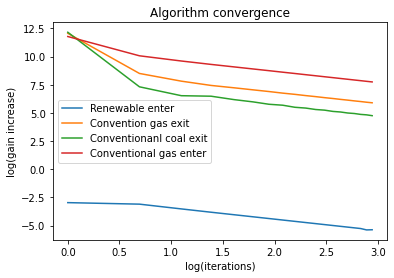

In [6]:
# Algorithm convergence illustration
logIter = np.log(range(1,Niter,1))

plt.figure()
plt.plot(logIter, np.log(save_ob_R[1:]), label = "Renewable enter")
plt.plot(logIter, np.log(save_ob_C[1:]), label = "Convention gas exit")
plt.plot(logIter, np.log(save_tildeob_C[1:]), label = "Conventionanl coal exit")
plt.plot(logIter, np.log(save_ob_C2[1:]), label = "Conventional gas enter")
plt.title("Algorithm convergence")
plt.xlabel('log(iterations)')
plt.ylabel('log(gain increase)')
plt.legend()
plt.show()

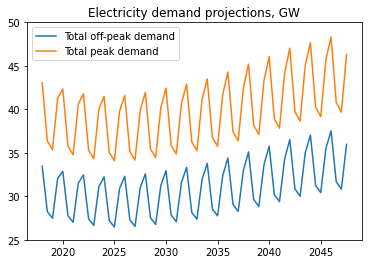

In [7]:
# Electricity demand projections, GW
plt.figure()
plt.plot(2018+T[:60],opdemand[:60],label='Total off-peak demand')
plt.plot(2018+T[:60],pdemand[:60],label='Total peak demand')
plt.title('Electricity demand projections, GW')
plt.ylim([25,50])
plt.legend(loc=2)
plt.show()